In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
from diffusion_models import Weighted_Cascade, Trivalency_Model, Independent_Cascade, Decreasing_Cascade, linear_threshold, general_threshold
import pandas as pd
from influence_max_algorithms import MIA

from nbc import non_backtracking_centrality
import pickle

import seaborn as sns


In [2]:
pb2020 = nx.read_gml('/Users/davidguzman/Documents/GitHub/Network-Science-final-Maximization-/Proud_Boys_Datsets/PB2020.gml')

In [3]:
#invert edge direction for PB2020
pb2020 = pb2020.reverse()

In [4]:
#number of nodes and edges
print("Number of nodes: ", pb2020.number_of_nodes())
print("Number of edges: ", pb2020.number_of_edges())

Number of nodes:  13217
Number of edges:  14477


### adding weighted cascade influence 

In [5]:
ICM_model_2020 = Independent_Cascade()
ICM_model_2020.fit(pb2020)

weighted_cascade_model_2020 = Weighted_Cascade()
weighted_cascade_model_2020.fit(pb2020)

trivalency_model_2020 = Trivalency_Model()
trivalency_model_2020.fit(pb2020)

In [7]:
#load the seeds
with open('seed_wcm.pickle', 'rb') as handle:
    seed_wcm = pickle.load(handle)
    
with open('seed_icm.pickle', 'rb') as handle:
    seed_icm = pickle.load(handle)

with open('seed_dc.pickle', 'rb') as handle:
    seed_dc = pickle.load(handle)

with open('seed_trivalency.pickle', 'rb') as handle:
    seed_trivalency = pickle.load(handle)

with open('seed_lt.pickle', 'rb') as handle:
    seed_lt = pickle.load(handle)

with open('seed_gt.pickle', 'rb') as handle:
    seed_gt = pickle.load(handle)

In [14]:
seed = ['principe_giovan',
 'Premises187',
 'MoralDK',
 'proudboy_',
 'enrique_tarrio',
 'GavinM_ProudBoy',
 'proudboy2012',
 'ProudBoysGBG',
 'ProudBoysUS',
 'ProudBoyzLondon',
 'ColoradoPOYB',
 'DetroitProudBoy',
 'Father_Rhyme',
 'Proudboy13',
 'IStand4Trump',
 'RallyPb',
 'mtn_pb',
 'Darktwistysnow',
 'mike29401',
 'demonik81',
 'Awful_Right',
 'BiomassMonitor',
 'my40thaccount',
 'TheFaction1776',
 'MediaRival',
 'KitDaniels1776',
 'LeeAnnMcAdoo',
 'libertytarian',
 'PrisonPlanet',
 'Cernovich',
 'ObamaMalik',
 'Lauren_Southern',
 'realDonaldTrump',
 'barstoolsports',
 'arielhelwani',
 'Qanon76',
 'TheNotoriousMMA',
 'TuckerCarlson',
 'DiamondandSilk',
 'seanhannity',
 'IngrahamAngle',
 'DineshDSouza',
 'w_terrence',
 'RepStevenSmith',
 'benshapiro',
 'RealCandaceO',
 'DonaldJTrumpJr',
 'IvankaTrump',
 'ZachZorlac',
 'DeusLingo',
 '28272209C',
 'Trump760',
 'Joe_Runge',
 'MikeMaroney11',
 'LolatheDoodette',
 'D0doubleD',
 'Schwa507',
 'NirajAryal20',
 'Barbarian_Bunny',
 'Prole357',
 'PavelMikoloski',
 'g28308990',
 'pastorfu',
 'P8riotPreacher',
 'iambryan_v',
 'Damien812',
 'katkozitza',
 'AdamsHasten',
 'owl_breath',
 'rickthetrollwh1',
 'Sinatra1fan',
 'hurricanefiend8',
 'shellie647',
 'Boon81914337',
 'ssgortizjorge',
 'InterchangeWdk',
 'JakeLedoux',
 'CASH9229',
 'recgildersleeve',
 'AZPatriotWife',
 'RandyB931',
 'Cali11958322',
 'LIZAIDA',
 'Allenglen14',
 'LMN7111',
 '_Death_Hack_',
 'nycshoot',
 'kcgreen77',
 'Hank_Rudr',
 'jeffhanson9',
 'TheRealNicoleG1',
 '_miLo',
 'paperboy311',
 'PutinKills',
 'Aghaveagh',
 'JoeMendi1',
 'Dingus118',
 'Dolla_bill2',
 'iam_marci',
 'KittenSlayer179']

In [15]:
#get the attributes of the nodes whose labels are in the seed
seed_nodes = [pb2020.nodes[node] for node in seed]
# for the nodes in seed_nodes, get all attributes and store them in a pandas dataframe
seed_nodes_and_attributes_df = pd.DataFrame(seed_nodes)
#add the labels of the nodes to the dataframe as the first column
seed_nodes_and_attributes_df.insert(0, 'label', seed)


In [16]:
#drop all columns after the statuses
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.iloc[:, :6]
#drop all rows that have a NaN value


In [17]:
new_seed = seed_nodes_and_attributes_df['label'].tolist()

In [18]:
individual_influence_wcm = []
for label in new_seed:
    activate_nums = weighted_cascade_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence_wcm.append(sum(activate_nums))

individual_influence_icm = []
for label in seed_icm:
    activate_nums = ICM_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence_icm.append(sum(activate_nums))

individual_influence_tr = []
for label in seed_trivalency:
    activate_nums = trivalency_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence_tr.append(sum(activate_nums))

In [19]:
seed_nodes_and_attributes_df['influence_wcm'] = individual_influence_wcm
seed_nodes_and_attributes_df['influence_icm'] = individual_influence_icm
seed_nodes_and_attributes_df['influence_tr'] = individual_influence_tr

In [20]:
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.dropna()

### adding Incinf of MIA as a metric for influence

In [75]:
mia = MIA(pb2020)

In [76]:
def assing_model_probs_to_weights(model):
    pb2020_model = pb2020.copy()
    for edge in pb2020_model.edges():
        prob = model.probability[model.label2id[edge[0]], model.label2id[edge[1]]]

        if pb2020_model.in_degree(edge[0]) == 0: # to avoid division by 0

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob + 0.00000001)) # to avoid diverging to - infinity
        else:

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob))
    return pb2020_model

In [77]:
pb2020_weighted_cascade = assing_model_probs_to_weights(weighted_cascade_model_2020)

In [78]:
Incinf = mia.initial_incinf(pb2020_weighted_cascade, 0.1)

Starting MIA intialization


100%|██████████| 13217/13217 [00:53<00:00, 248.84it/s]


In [79]:
#add influence to the seed_nodes_and_attributes_df where label is the same as the key in Incinf
seed_nodes_and_attributes_df['influence_incinf_MIA'] = seed_nodes_and_attributes_df['label'].map(dict(Incinf))

### adding traditional centrality metrics 

In [22]:
seed_nodes_and_centralities_df = seed_nodes_and_attributes_df.copy()
#keep only the columns 'label', 'influence_wcm', 'influence_incinf_MIA'
seed_nodes_and_centralities_df = seed_nodes_and_centralities_df[['label', 'influence_wcm', 'influence_icm', 'influence_tr']]

In [23]:
seed_nodes_and_centralities_df

,label,influence_wcm,influence_icm,influence_tr
0,principe_giovan,550.08,824.12,1.17
2,MoralDK,237.15,581.00,1.57
7,ProudBoysGBG,42.27,81.50,1.10
8,ProudBoysUS,35.00,35.00,1.00
10,ColoradoPOYB,6.94,10.00,1.01
...,...,...,...,...
95,JoeMendi1,1.00,38.98,1.00
96,Dingus118,1.00,33.64,1.00
97,Dolla_bill2,1.00,49.40,1.10
98,iam_marci,1.00,47.75,1.39


In [24]:
degree_centrality_dict = nx.degree_centrality(pb2020)
seed_nodes_and_centralities_df['degree_centrality'] = seed_nodes_and_centralities_df['label'].map(degree_centrality_dict)
closeness_centrality_dict = nx.closeness_centrality(pb2020)
seed_nodes_and_centralities_df['closeness_centrality'] = seed_nodes_and_centralities_df['label'].map(closeness_centrality_dict)
betweenness_centrality_dict = nx.betweenness_centrality(pb2020)
seed_nodes_and_centralities_df['betweenness_centrality'] = seed_nodes_and_centralities_df['label'].map(betweenness_centrality_dict)
eigenvector_centrality_dict = nx.eigenvector_centrality(pb2020)
seed_nodes_and_centralities_df['eigenvector_centrality'] = seed_nodes_and_centralities_df['label'].map(eigenvector_centrality_dict)
pagerank_dict = nx.pagerank(pb2020)
seed_nodes_and_centralities_df['pagerank'] = seed_nodes_and_centralities_df['label'].map(pagerank_dict)
k_core_centralities_dict = nx.core_number(pb2020)
seed_nodes_and_centralities_df['k_core_centrality'] = seed_nodes_and_centralities_df['label'].map(k_core_centralities_dict)

In [36]:
pb2020_int = nx.convert_node_labels_to_integers(pb2020)
#get the node labels in a list
node_labels = list(pb2020.nodes())
# calcualate the non-backtrack centrality
non_backtrack_centralities = non_backtracking_centrality(pb2020_int)
# use node labels to create a dictionary
non_backtrack_centralities_dict = dict(zip(node_labels, non_backtrack_centralities))
# add the non-backtrack centrality to the dataframe
seed_nodes_and_centralities_df['non_backtrack_centrality'] = seed_nodes_and_centralities_df['label'].map(non_backtrack_centralities_dict)

In [25]:
#remove column 'listed' from the dataframe
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.drop(columns=['listed'])

In [26]:
seed_nodes_and_attributes_df.head()

,label,faves,followers,friends,statuses,influence_wcm,influence_icm,influence_tr
0,principe_giovan,8253.0,625.0,605.0,693.0,550.08,824.12,1.17
2,MoralDK,14609.0,216.0,322.0,6421.0,237.15,581.00,1.57
7,ProudBoysGBG,407.0,48.0,50.0,213.0,42.27,81.50,1.10
8,ProudBoysUS,604.0,3096.0,44.0,482.0,35.00,35.00,1.00
10,ColoradoPOYB,1.0,12.0,9.0,5.0,6.94,10.00,1.01


In [37]:
seed_nodes_and_centralities_df.head()

,label,influence_wcm,influence_icm,influence_tr,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank,k_core_centralities,non_backtrack_centrality
0,principe_giovan,550.08,824.12,1.17,0.089134,0.048710,0.011663,9.238840e-03,0.015961,4,0.105391
2,MoralDK,237.15,581.00,1.57,0.031931,0.062981,0.015487,4.549906e-05,0.003880,4,0.015310
7,ProudBoysGBG,42.27,81.50,1.10,0.005448,0.057879,0.000741,3.209253e-05,0.000500,4,0.005268
8,ProudBoysUS,35.00,35.00,1.00,0.041465,0.069290,0.000596,6.239610e-07,0.013938,3,0.001045
10,ColoradoPOYB,6.94,10.00,1.01,0.001438,0.041696,0.000069,3.136390e-05,0.000142,4,0.002724


### adding node propeties

In [28]:
seed_nodes_and_properties_df  = seed_nodes_and_attributes_df.copy()
seed_nodes_and_properties_df = seed_nodes_and_properties_df[['label', 'influence_wcm', 'influence_icm', 'influence_tr']]

In [29]:
in_degree_dict = dict(pb2020.in_degree())
seed_nodes_and_properties_df['in_degree'] = seed_nodes_and_properties_df['label'].map(in_degree_dict)
out_degree_dict = dict(pb2020.out_degree())
seed_nodes_and_properties_df['out_degree'] = seed_nodes_and_properties_df['label'].map(out_degree_dict)
clustering_dict = nx.clustering(pb2020)
seed_nodes_and_properties_df['clustering'] = seed_nodes_and_properties_df['label'].map(clustering_dict)
average_neighbor_degree_dict = nx.average_neighbor_degree(pb2020, source = 'out', target = 'out')
seed_nodes_and_properties_df['average_neighbor_degree'] = seed_nodes_and_properties_df['label'].map(average_neighbor_degree_dict)
#eccentricity_dict = nx.eccentricity(pb2020) #network is not strongly connected
#seed_nodes_and_properties_df['eccentricity'] = seed_nodes_and_properties_df['label'].map(eccentricity_dict)

In [30]:
seed_nodes_and_properties_df.head()

,label,influence_wcm,influence_icm,influence_tr,in_degree,out_degree,clustering,average_neighbor_degree
0,principe_giovan,550.08,824.12,1.17,604,574,0.0,0.547038
2,MoralDK,237.15,581.00,1.57,167,255,0.0,0.400000
7,ProudBoysGBG,42.27,81.50,1.10,23,49,0.0,0.122449
8,ProudBoysUS,35.00,35.00,1.00,514,34,0.0,0.235294
10,ColoradoPOYB,6.94,10.00,1.01,10,9,0.0,0.000000


## plotting

### attributes

Text(0.5, 0.98, 'Scatterplots of node influence and attributes')

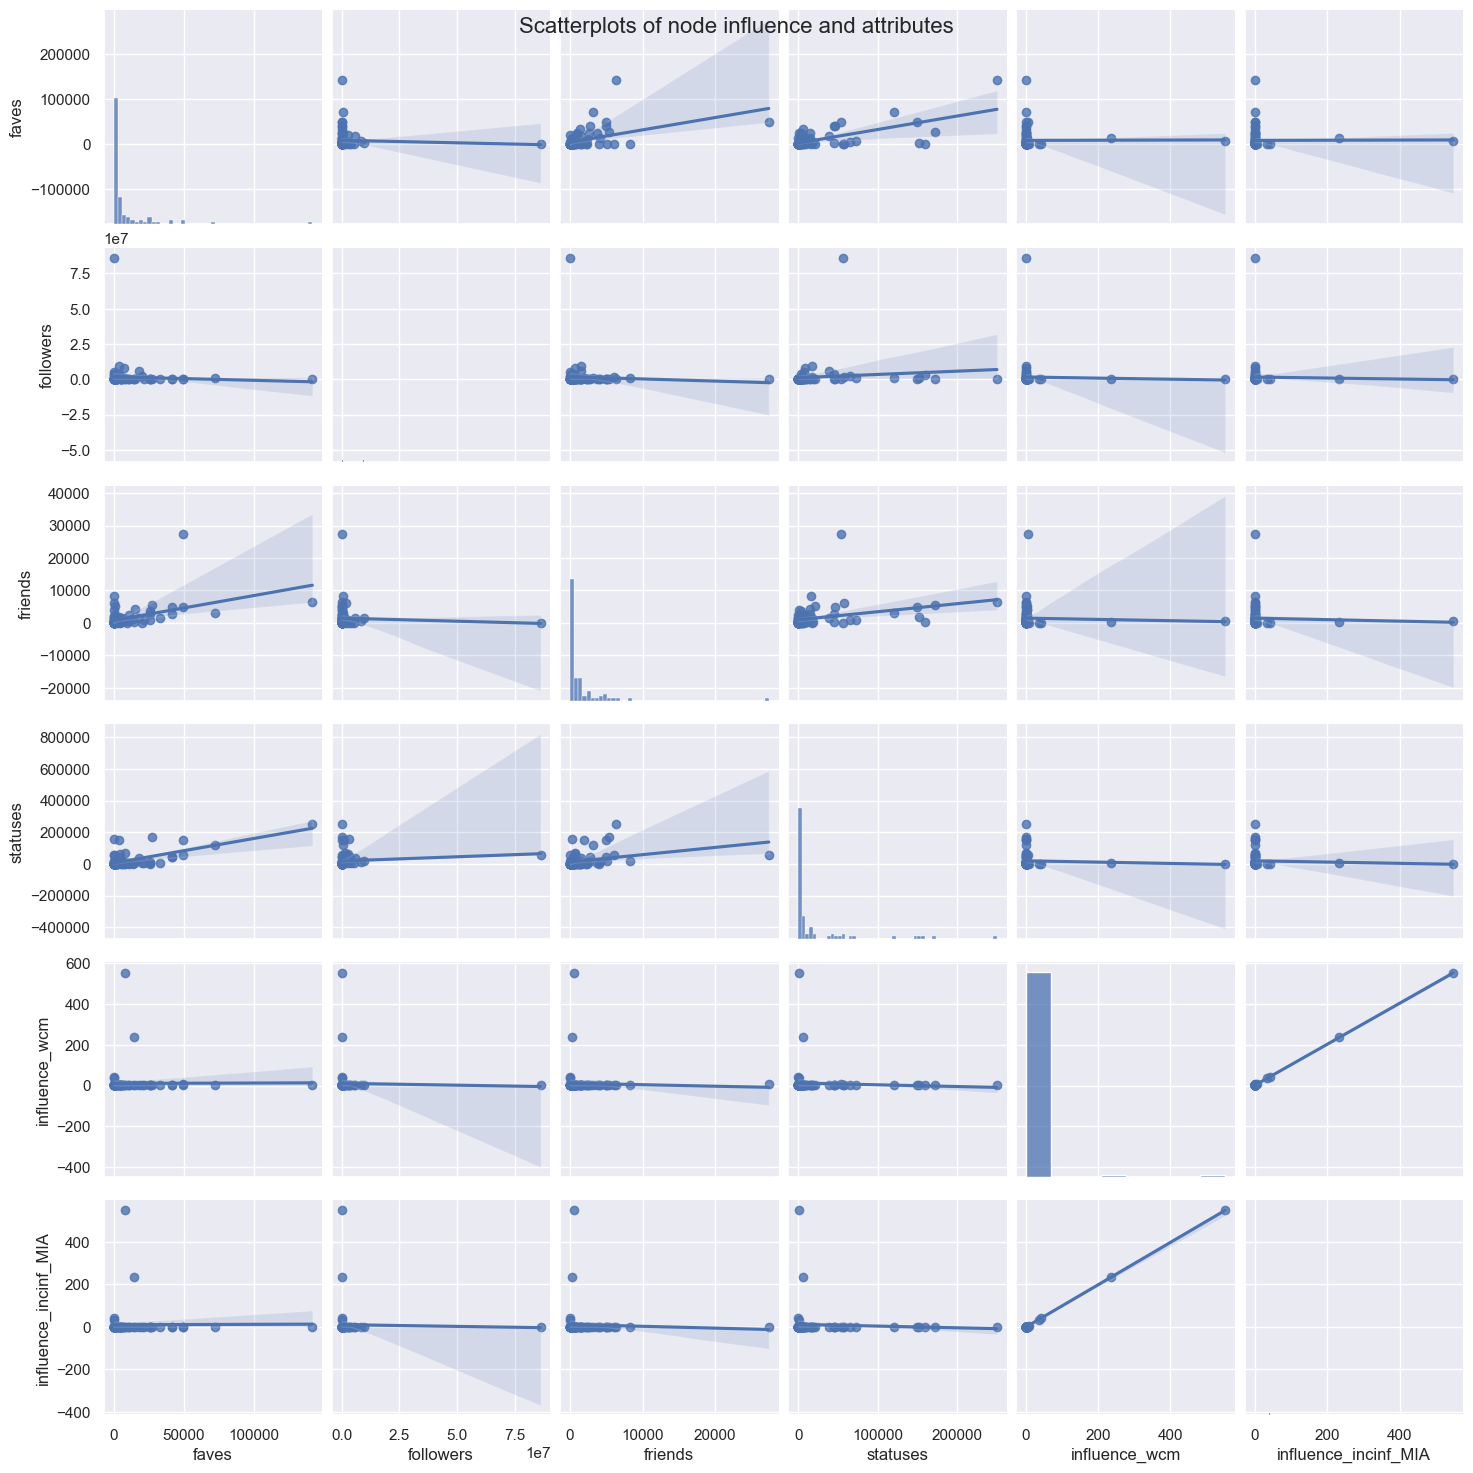

In [55]:
# plot scatterplots for each attribute in one plot wiht seaborn with correlation lines and coefficients numbers added to the plot
sns.pairplot(seed_nodes_and_attributes_df, kind="reg")
#add title to the plot
plt.suptitle('Scatterplots of node influence and attributes', fontsize=16)


/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_23737/2666190049.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(seed_nodes_and_attributes_df.corr(), annot=True, cmap=colormap)


Text(0.5, 1.0, 'Correlation matrix of node influence and attributes')

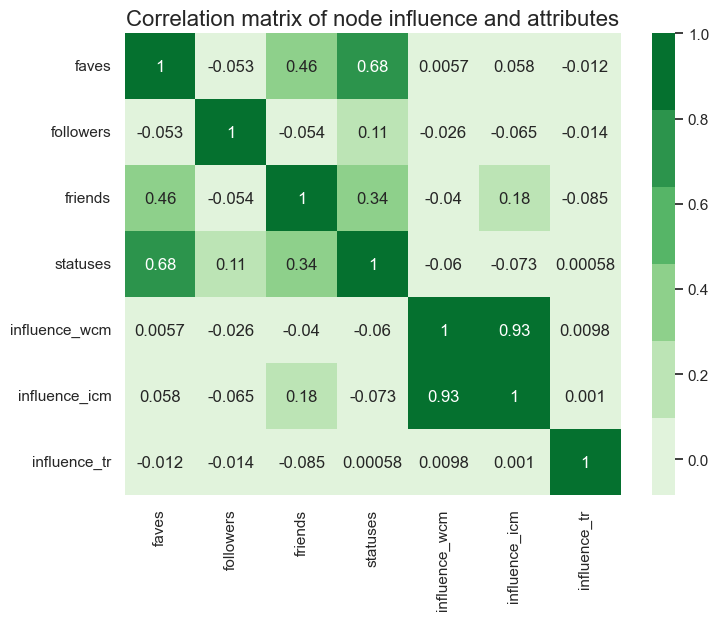

In [31]:
#print correlation matrix
#make iamge bigger
sns.set(rc={'figure.figsize':(8,6)})
colormap = sns.color_palette("Greens")
sns.heatmap(seed_nodes_and_attributes_df.corr(), annot=True, cmap=colormap)
#add title to the plot
plt.title('Correlation matrix of node influence and attributes', fontsize=16)

### centralities

Text(0.5, 0.98, 'Scatterplots of node influence and centralities')

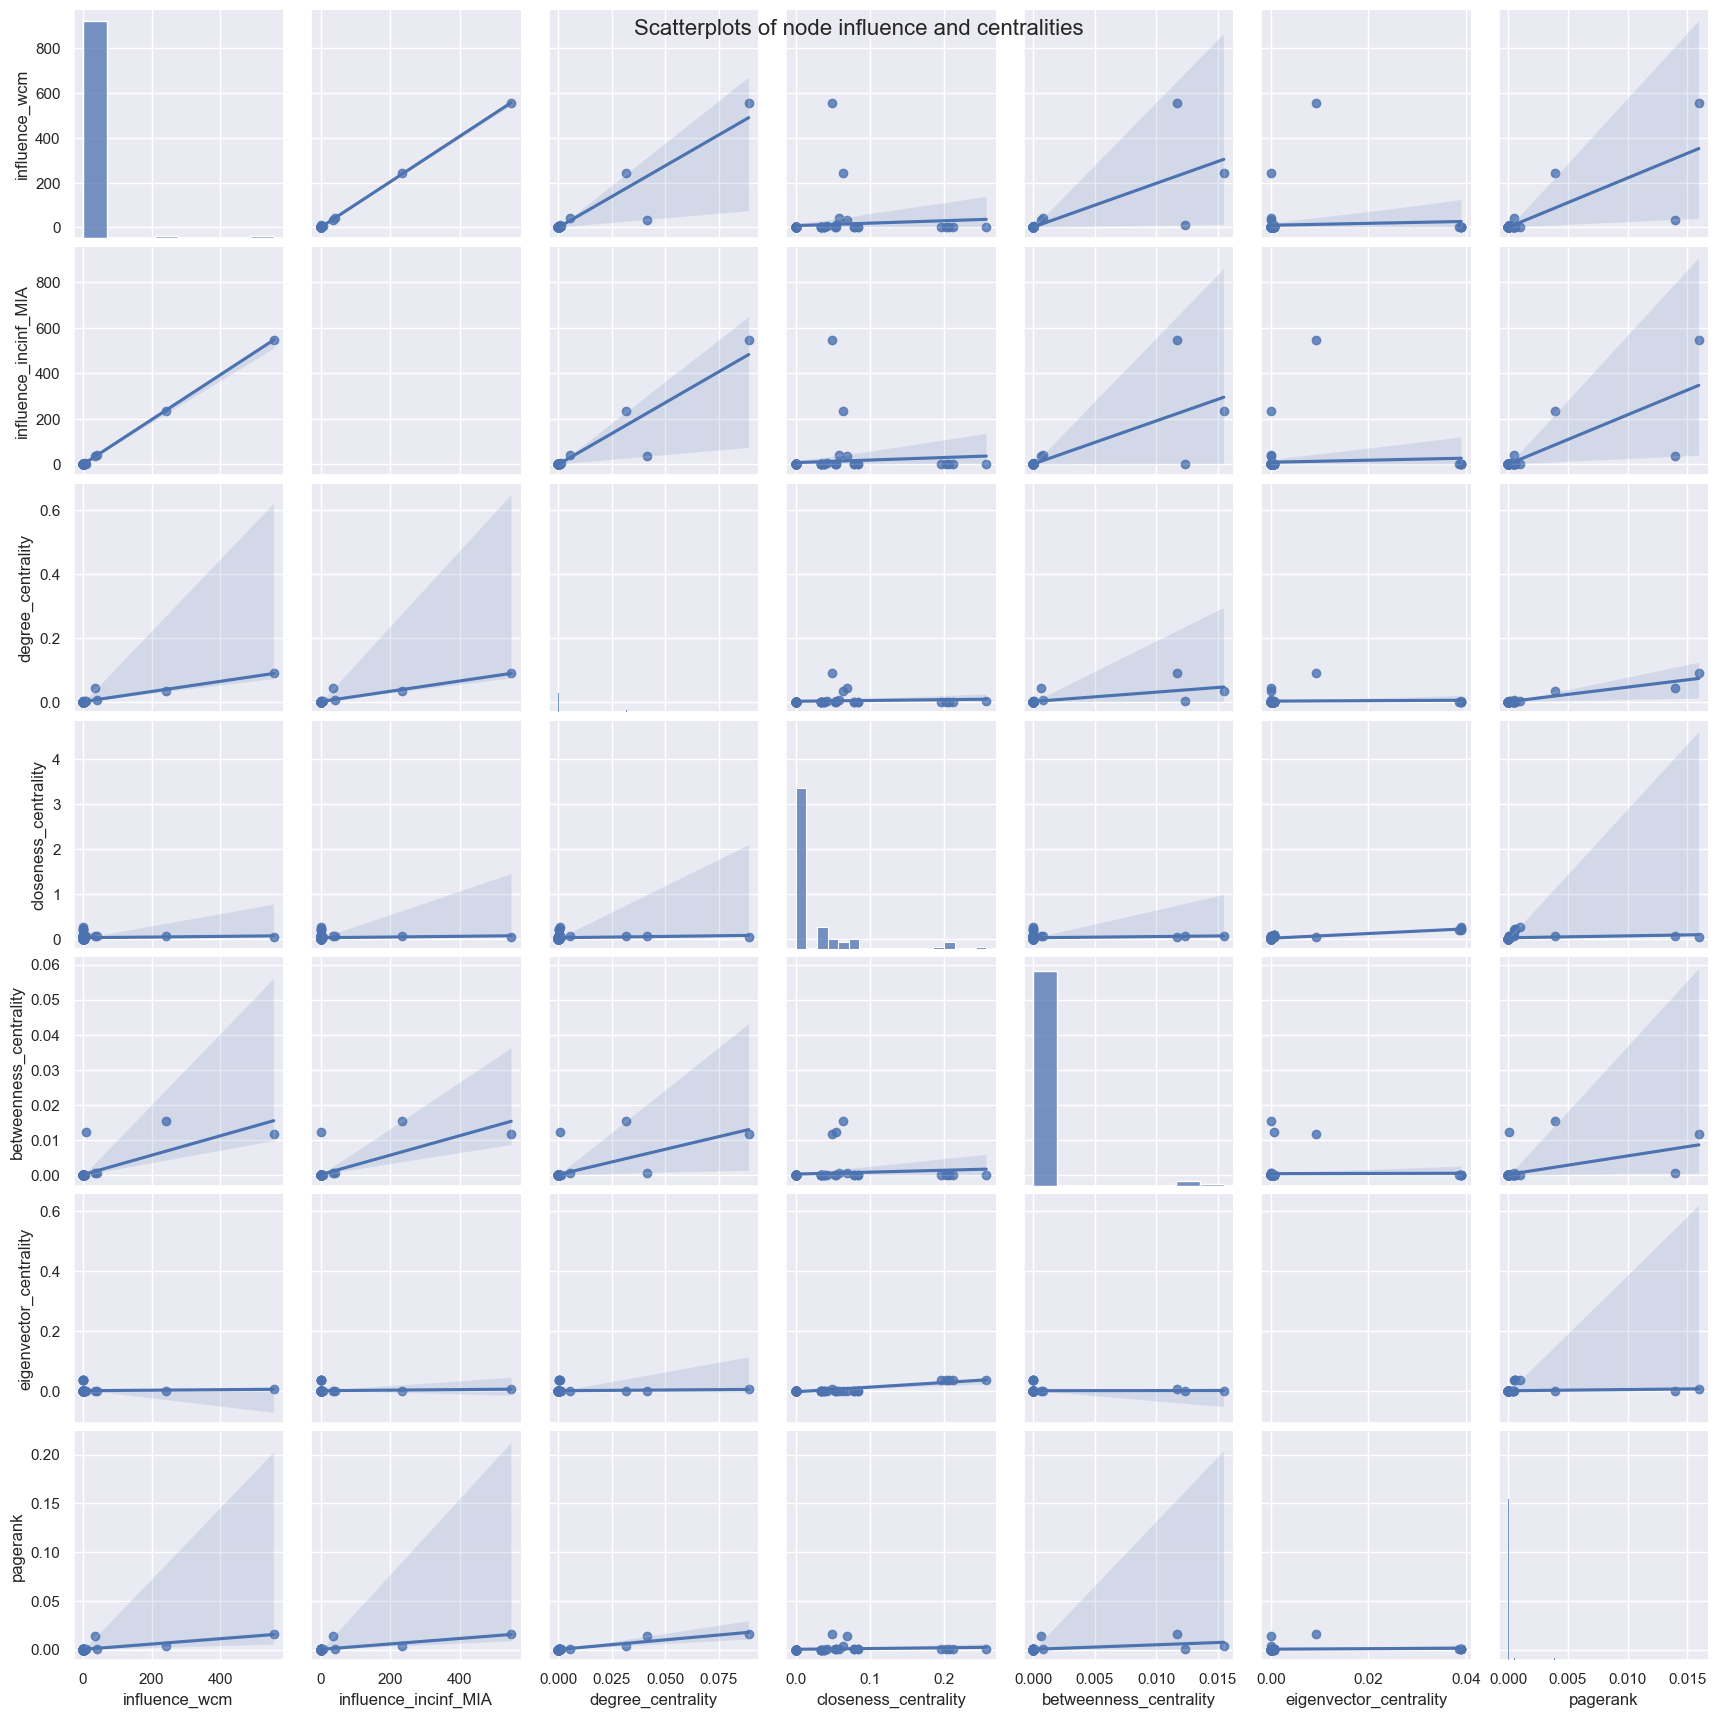

In [94]:
sns.pairplot(seed_nodes_and_centralities_df, kind="reg")
#add title to the plot
plt.suptitle('Scatterplots of node influence and centralities', fontsize=16)

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_23737/174809786.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(seed_nodes_and_centralities_df.corr(), annot=True, cmap=colormap)


Text(0.5, 1.0, 'Correlation matrix of node influence and centralities')

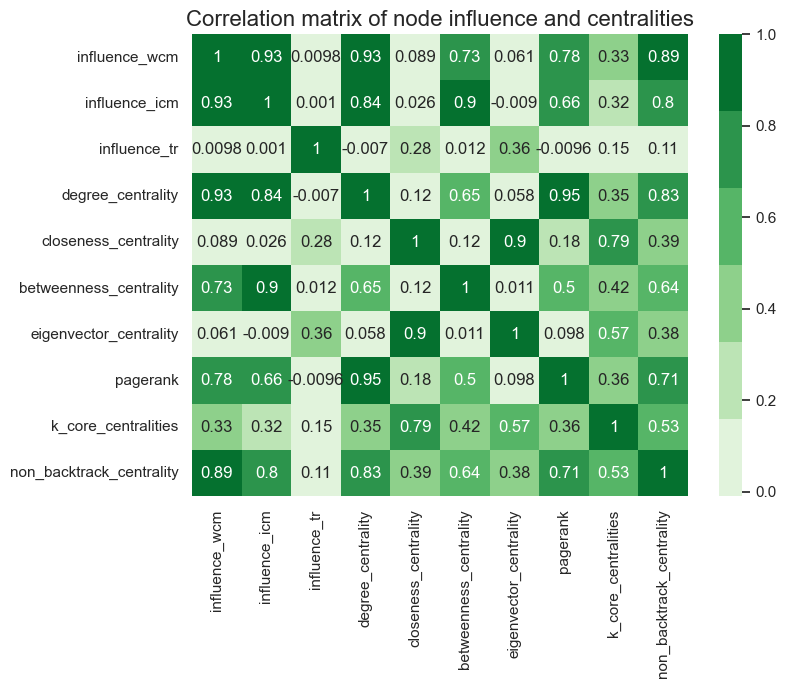

In [38]:
sns.set(rc={'figure.figsize':(8,6)})
colormap = sns.color_palette("Greens")
sns.heatmap(seed_nodes_and_centralities_df.corr(), annot=True, cmap=colormap)
#add title to the plot
plt.title('Correlation matrix of node influence and centralities', fontsize=16)

### node properties

Text(0.5, 0.98, 'Scatterplots of node influence and properties')

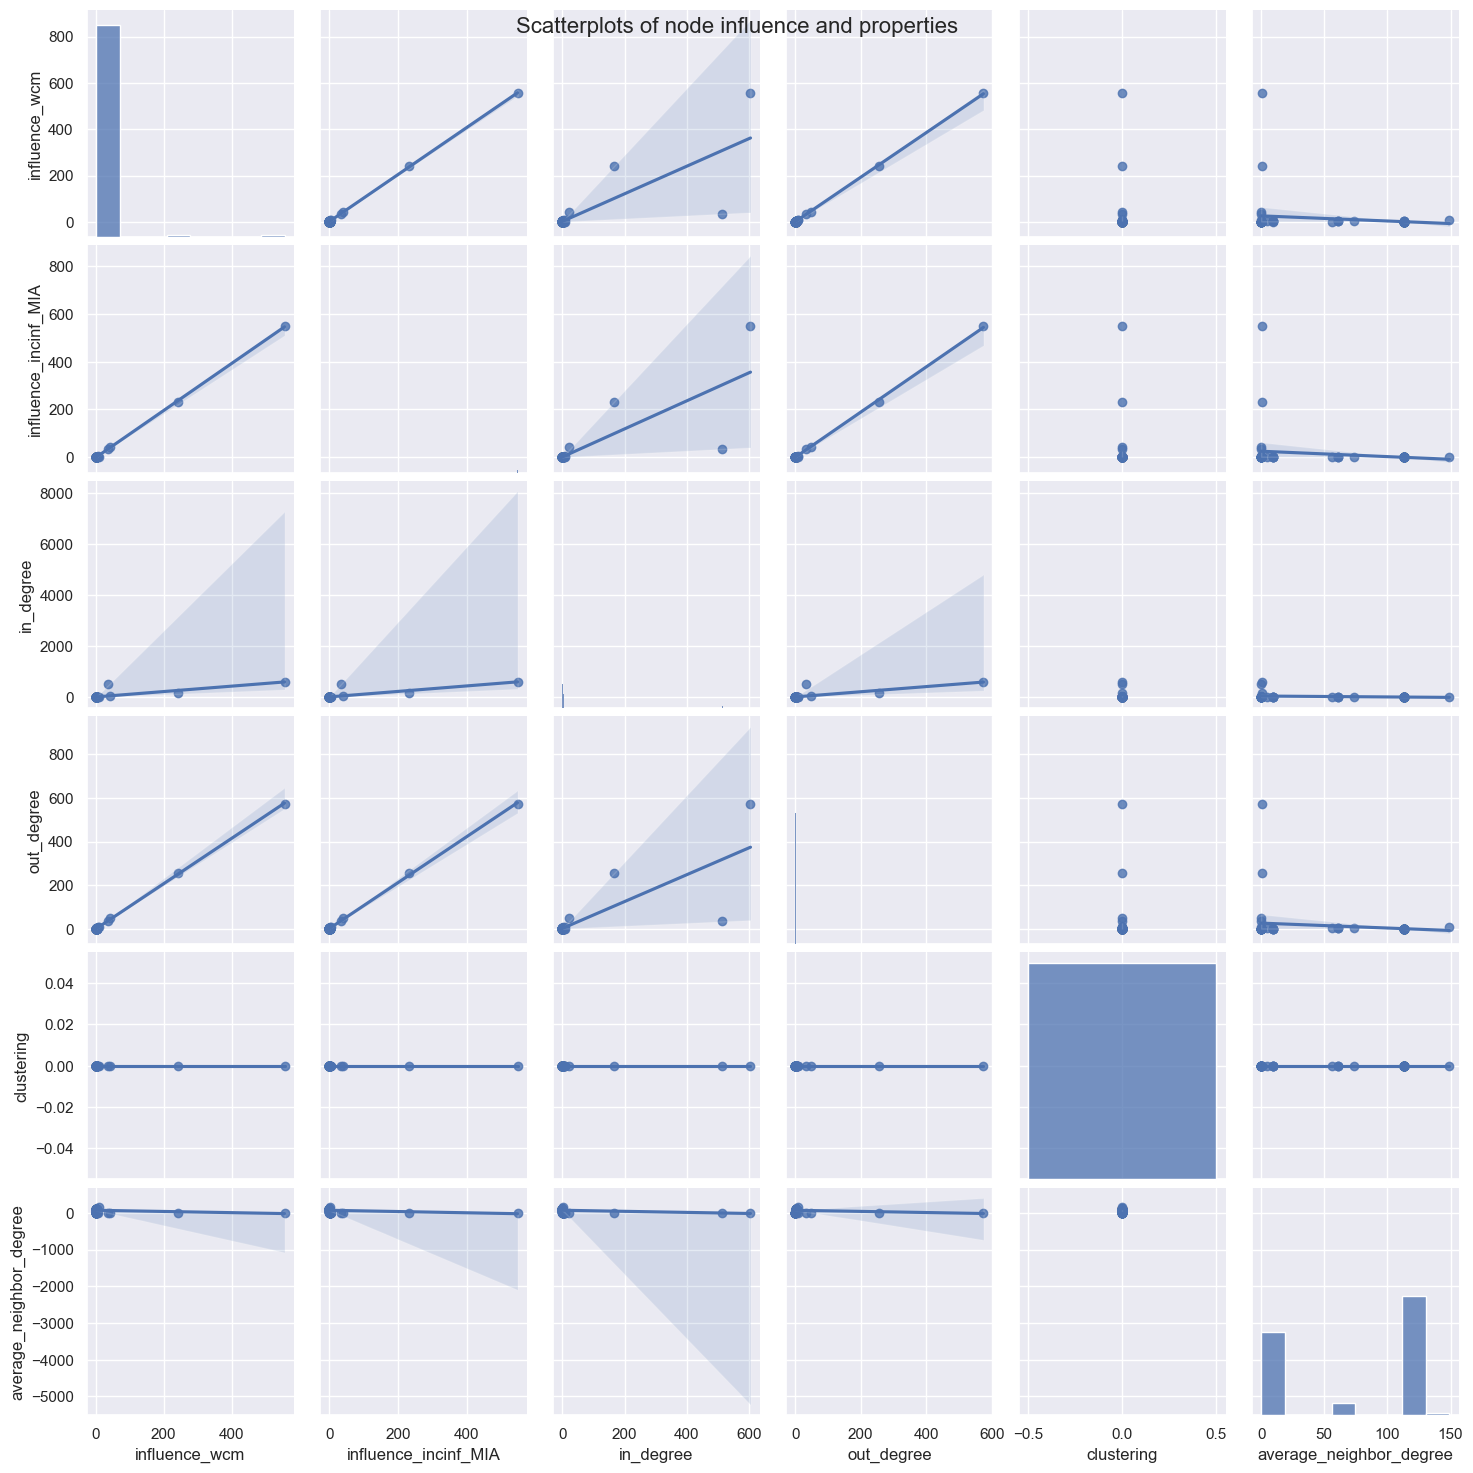

In [117]:
sns.pairplot(seed_nodes_and_properties_df, kind="reg")
#add title to the plot
plt.suptitle('Scatterplots of node influence and properties', fontsize=16)

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_23737/4021183938.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(seed_nodes_and_properties_df.corr(), annot=True, cmap=colormap)


Text(0.5, 1.0, 'Correlation matrix of node influence and properties')

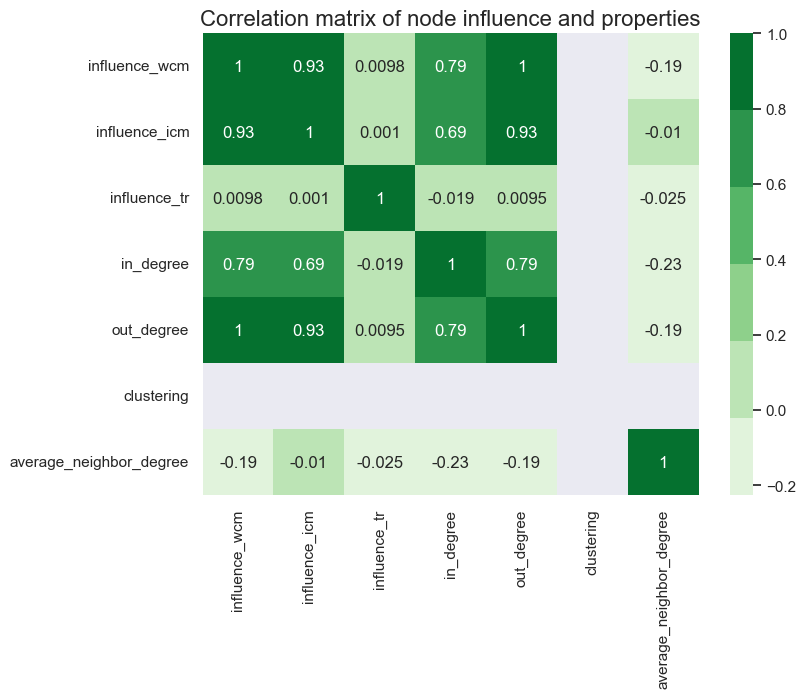

In [33]:
sns.set(rc={'figure.figsize':(8,6)})
colormap = sns.color_palette("Greens")
sns.heatmap(seed_nodes_and_properties_df.corr(), annot=True, cmap=colormap)
#add title to the plot
plt.title('Correlation matrix of node influence and properties', fontsize=16)